# FinOpt: Complete Workflow Validation

# Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date

import matplotlib.pyplot as plt

# --- Standard libs ---
import numpy as np
import pandas as pd

# --- FinOpt modules ---
from src.income import FixedIncome, IncomeModel, VariableIncome
from src.portfolio import Account, Portfolio
from src.returns import ReturnModel
from src.utils import monthly_to_annual
from src.model import FinancialModel, SimulationResult
from src.optimization import CVaROptimizer
from src.goals import IntermediateGoal, TerminalGoal

# Configuration: Seasonality and Contribution

In [2]:
# --- Seasonality pattern for variable income (12 months, Jan–Dec) ---

# Structure: months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
#                      "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

seasonality_variable = [0.00, 0.00, 0.00, 1.22, 1.22, 1.16,
                        1.24, 1.10, 0.50, 0.90, 1.00, 1.31]

monthly_contrib_fixed = [0.20, 0.20, 0.20, 0.22, 0.25, 0.25,
                         0.23, 0.23, 0.20, 0.20, 0.20, 0.10]

monthly_contrib_variable = [1.0] * 12

monthly_contribution ={"fixed": monthly_contrib_fixed, "variable": monthly_contrib_variable}

# Initialize FinancialModel 

In [3]:
# IncomeModel Instantiation
income = IncomeModel(
    fixed=FixedIncome(
        base=1_480_000.0,       # CLP/month
        annual_growth=0.03,     # 3% nominal annual growth
        salary_raises={
            date(2026, 4, 1): 400_000,  # +400k in April 2026
            date(2027, 4, 1): 400_000,   # +400k in April 2027
            date(2028, 6, 1): 300_000   # +300k in Jun 2028
        },
        name="fixed"
    ),
    variable=VariableIncome(
        base=100_000.0,         # Base variable income
        seasonality=seasonality_variable,
        sigma=0.10,             # 10% monthly noise
        floor=0.0,              # No negative income
        cap=400_000.0,          # Maximum 400k/month
        annual_growth=0.0,      # No growth in variable
        name="variable"
    ),
    monthly_contribution = monthly_contribution
)

# --- Account configuration ---
accounts = [
    Account.from_annual(
        name="Cuenta Ahorro Vivienda (BE)",
        annual_return=0.025,
        annual_volatility=0.01,
        initial_wealth=1600000
    ),
    Account.from_annual(
        name="Conservative Clooney (Fintual)",
        annual_return=0.08,
        annual_volatility=0.09,
        initial_wealth=744747
    ),
    Account.from_annual(
        name="Moderate Pitt (Fintual)",
        annual_return=0.12,
        annual_volatility=0.13,
        initial_wealth=496879
    )
]

# --- Correlation matrix (2x2) ---
# UF portfolio have moderate positive correlation (rho = 0.2)
correlation_matrix = np.array([
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.5],
    [0.0, 0.5, 1.0]
])

# --- Initialize FinancialModel ---
model = FinancialModel(income, accounts, default_correlation = correlation_matrix)
model

FinancialModel(M=3, accounts=['Cuenta Ahorro Vivienda (BE)', 'Conservative Clooney (Fintual)', 'Moderate Pitt (Fintual)'], cache=enabled)

# Simulation parameters

In [4]:
# --- Simulation parameters ---
n_sims = 500
months = 26  
start_date = date(2025, 11, 1)

# Income Module

Total monthly income at time $t$ is composed of fixed and variable parts:

$$
Y_t = y_t^{\text{fixed}} + Y_t^{\text{variable}}
$$

## **Fixed Income**

The fixed component, $y_t^{\text{fixed}}$, reflects a baseline salary subject to compounded annual growth $g$ and scheduled raises ${d_k, \Delta_k}$ (e.g., promotions or tenure milestones):

$$y_t^{\text{fixed}} = \text{current\_salary}(t) \cdot (1+m)^{\Delta t}$$

where $m = (1 + g)^{1/12} - 1$ is the **monthly compounded rate**, and $\Delta t$ represents time since the last raise.

## **Variable Income**

The variable component, $Y_t^{\text{variable}}$, models irregular income sources (e.g., freelance work or bonuses) with:

* **Seasonality**: $s \in \mathbb{R}^{12}$ (multiplicative monthly factors),
* **Noise**: $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ (Gaussian shocks),
* **Growth**: same compounded rate $m$ applied to a base income level,
* **Boundaries**: optional floor and cap constraints.

The underlying stochastic projection is:

$$
\tilde{Y}_t = \max(\text{floor},\ \mu_t (1 + \epsilon_t)), \quad \text{where } \mu_t = \text{base} \cdot (1 + m)^t \cdot s_{(t \bmod 12)}
$$

Then, guardrails are applied as:

$$
Y_t^{\text{variable}} = \begin{cases}
0 & \text{if } \tilde{Y}_t < 0 \\
\tilde{Y}_t & \text{if } 0 \leq \tilde{Y}_t \leq \text{cap} \\
\text{cap} & \text{if } \tilde{Y}_t > \text{cap}
\end{cases}
$$

> **Note:** In expectation (ignoring noise truncation), $\mathbb{E}[Y_t] = y_t^{\text{fixed}} + \mu_t$

## Income Projection

Dual-axis plot with:
- **Left axis**: Fixed income (deterministic) + Total income
- **Right axis**: Variable income (stochastic with trajectories)
- **Trajectories**: Individual noise realizations (n=300)
- **Confidence band**: 95% CI for variable income

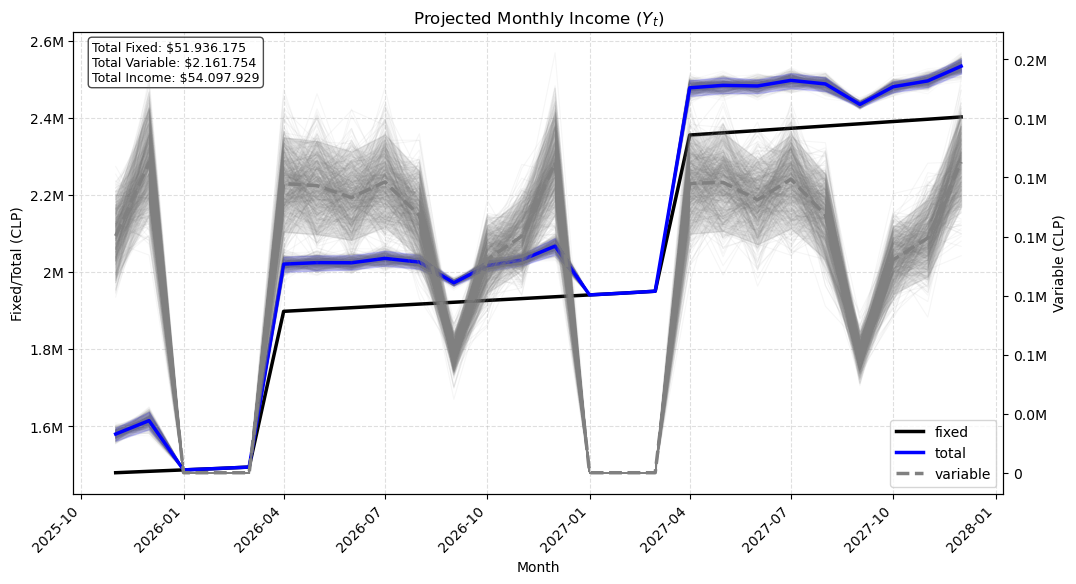

In [5]:
# Income Projection Simulation
model.plot(mode='income', T=months, start=start_date)

## Contribution Projection

A fraction of income is allocated each month through calendar-rotating schedules:
$$
A_t = \alpha_{(t \bmod 12)}^{f} \cdot y_t^{\text{fixed}} + \alpha_{(t \bmod 12)}^{v} \cdot Y_t^{\text{variable}}
$$

where $\alpha^f, \alpha^v \in [0,1]^{12}$ control the fixed and variable contribution rates by applying the 12-month fractional arrays to projected incomes, rotated according to `start` date and repeated cyclically for horizons > 12 months.

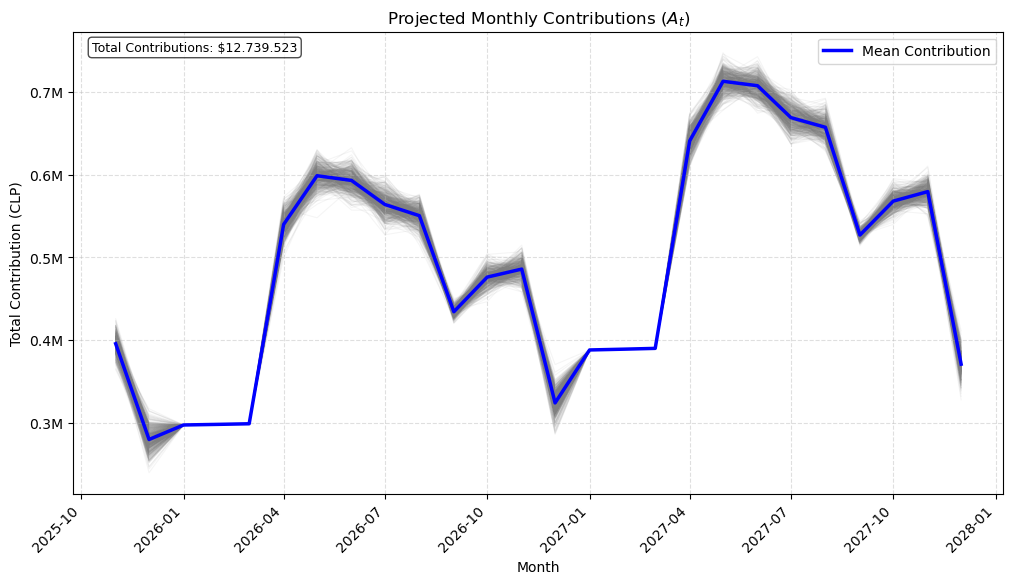

In [6]:
# Contribution Projection Simulation
model.plot(mode='contributions', T=months, start=start_date)

# Return Module

## Multi-Account Return Model

For $M$ accounts with correlated returns:

$$1 + R_t^m \sim \text{LogNormal}(\mu_{\log}^m, \Sigma)$$

where $\Sigma = D \cdot \rho \cdot D$ is the covariance matrix:
- $D = \text{diag}(\sigma_{\log}^1, \ldots, \sigma_{\log}^M)$
- $\rho \in \mathbb{R}^{M \times M}$ is the correlation matrix (symmetric, PSD)



## Monthly Return Distribution (Marginal Analysis)

Visualizes IID monthly returns across both accounts with 4 panels:
- **Trajectories**: Individual paths for each account
- **Histograms**: Marginal distributions (overlaid)
- **Statistics**: Mean, std, quantiles per account

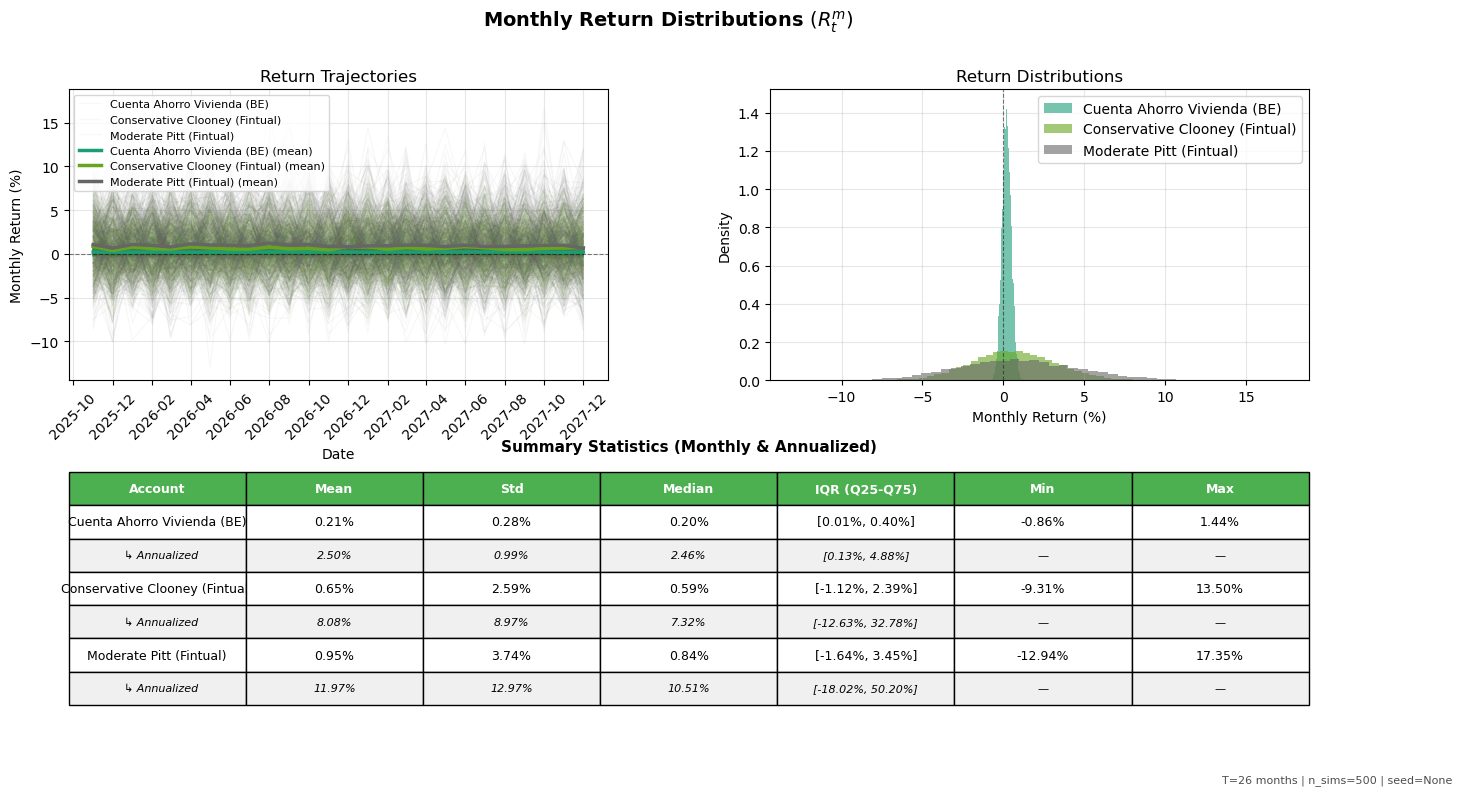

In [7]:
model.plot(mode = 'returns', T = months, start=start_date)

## Cumulative Returns per Account

For $M$ accounts with correlated returns:
$$R_{\text{cm}}^m(T) = \prod_{t=0}^{T-1}(1 + R_t^m) - 1$$
**Cross-sectional correlation** persists through time but does not compound.

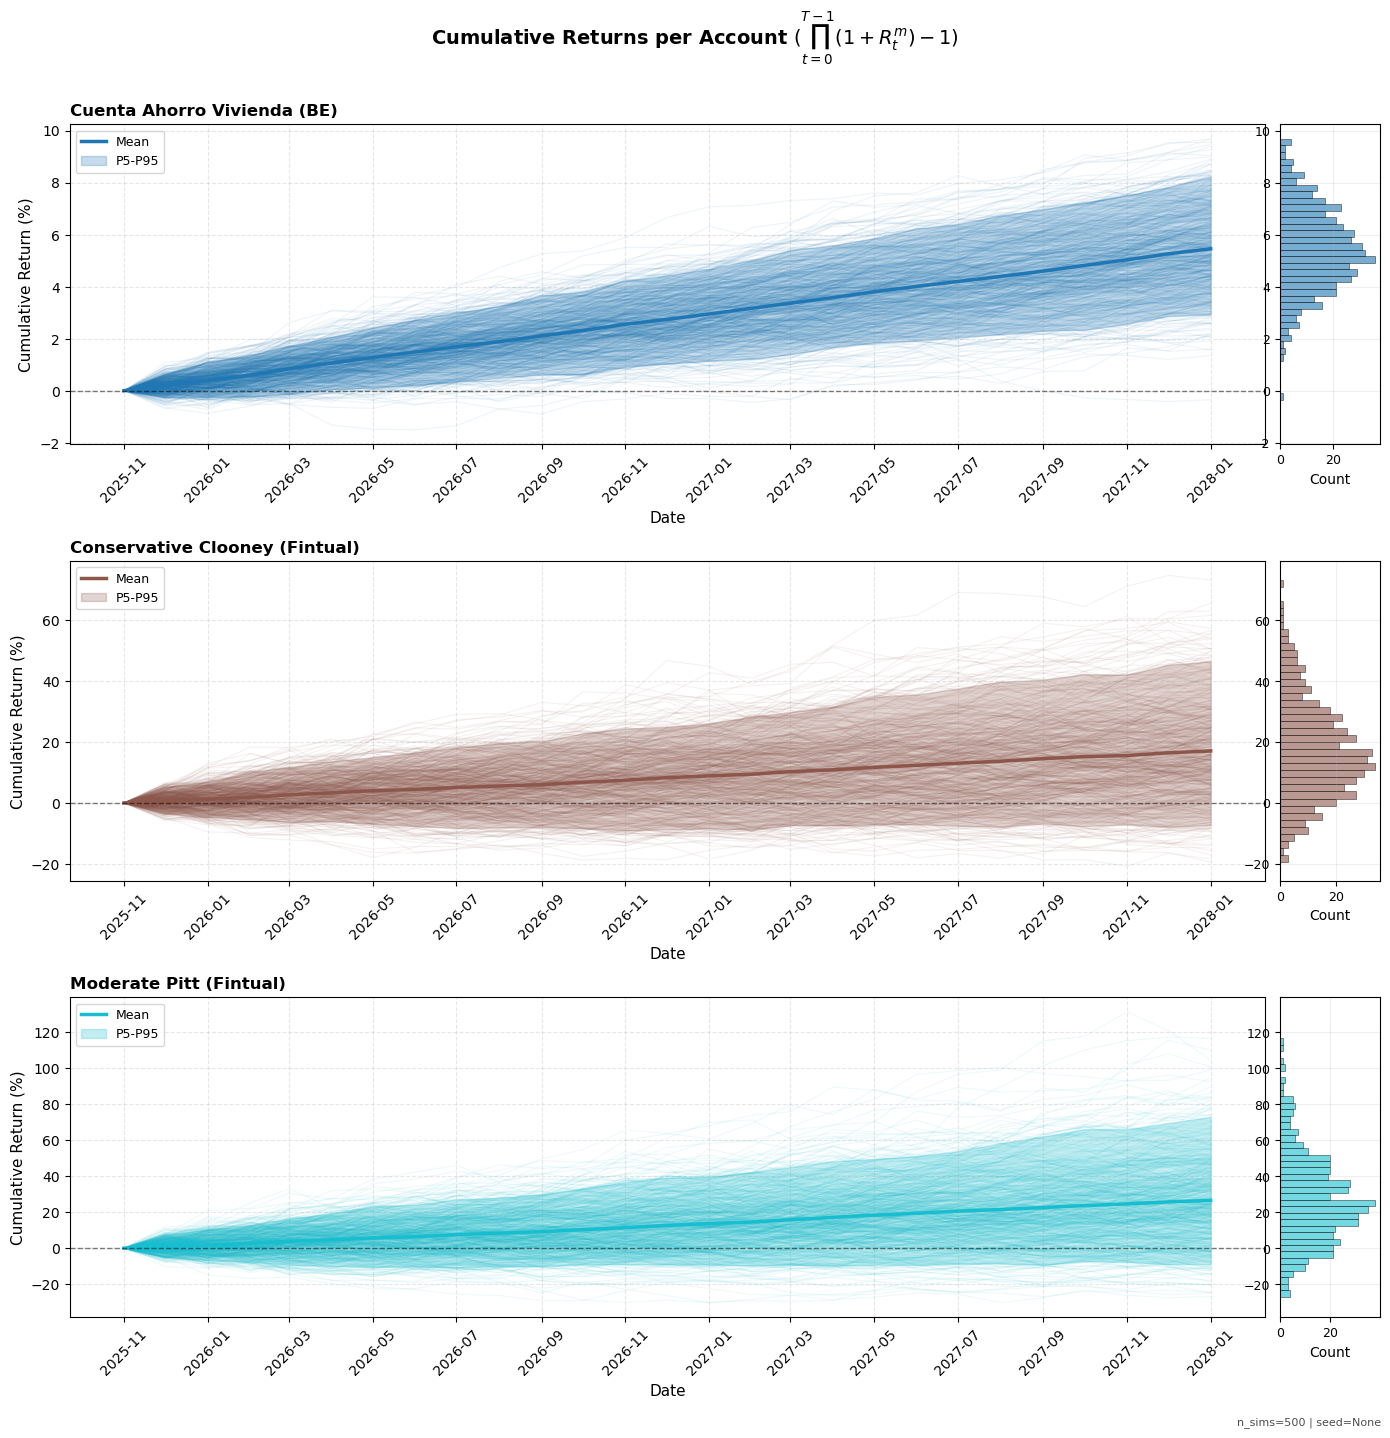

In [8]:
model.plot(mode = 'returns_cumulative', T = months, start=start_date)

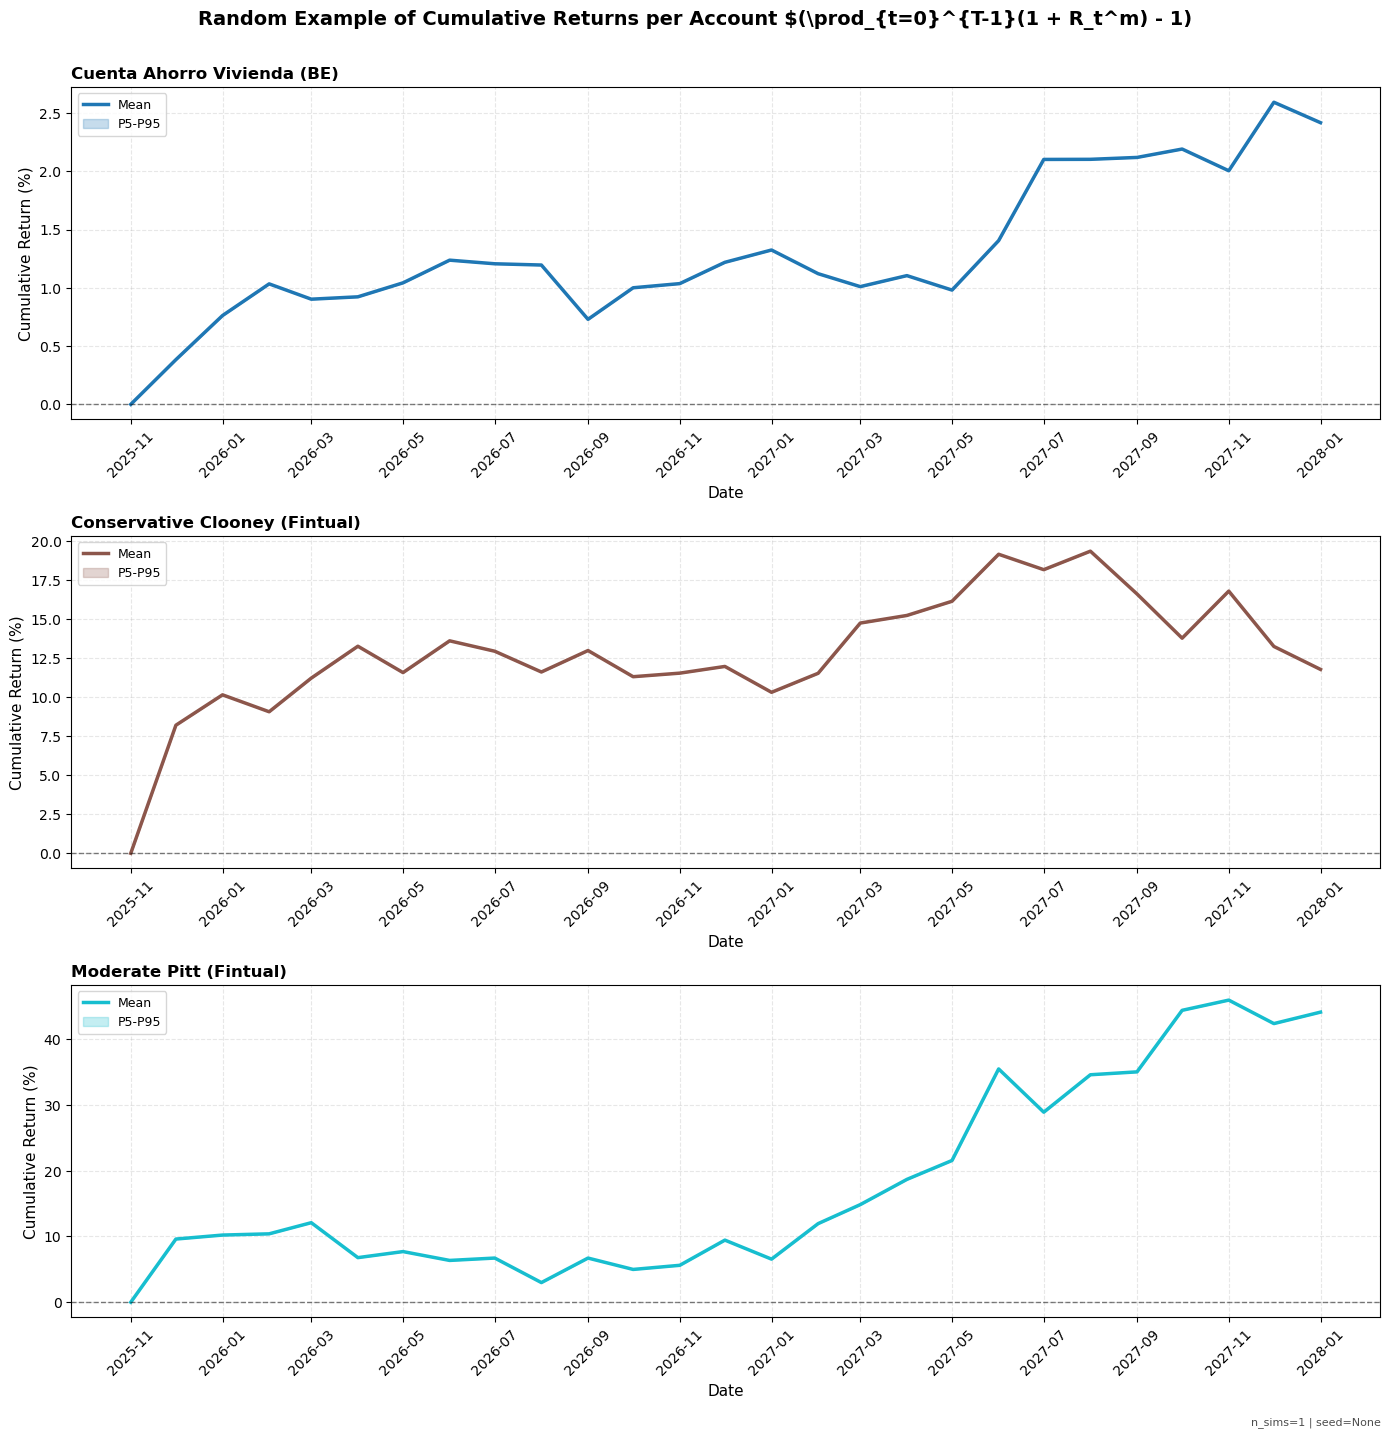

In [9]:
model.plot(mode = 'returns_cumulative', T = months, start=start_date, n_sims=1, title= r'Random Example of Cumulative Returns per Account $(\prod_{t=0}^{T-1}(1 + R_t^m) - 1)')

## Horizon Analysis: Time Diversification by Account

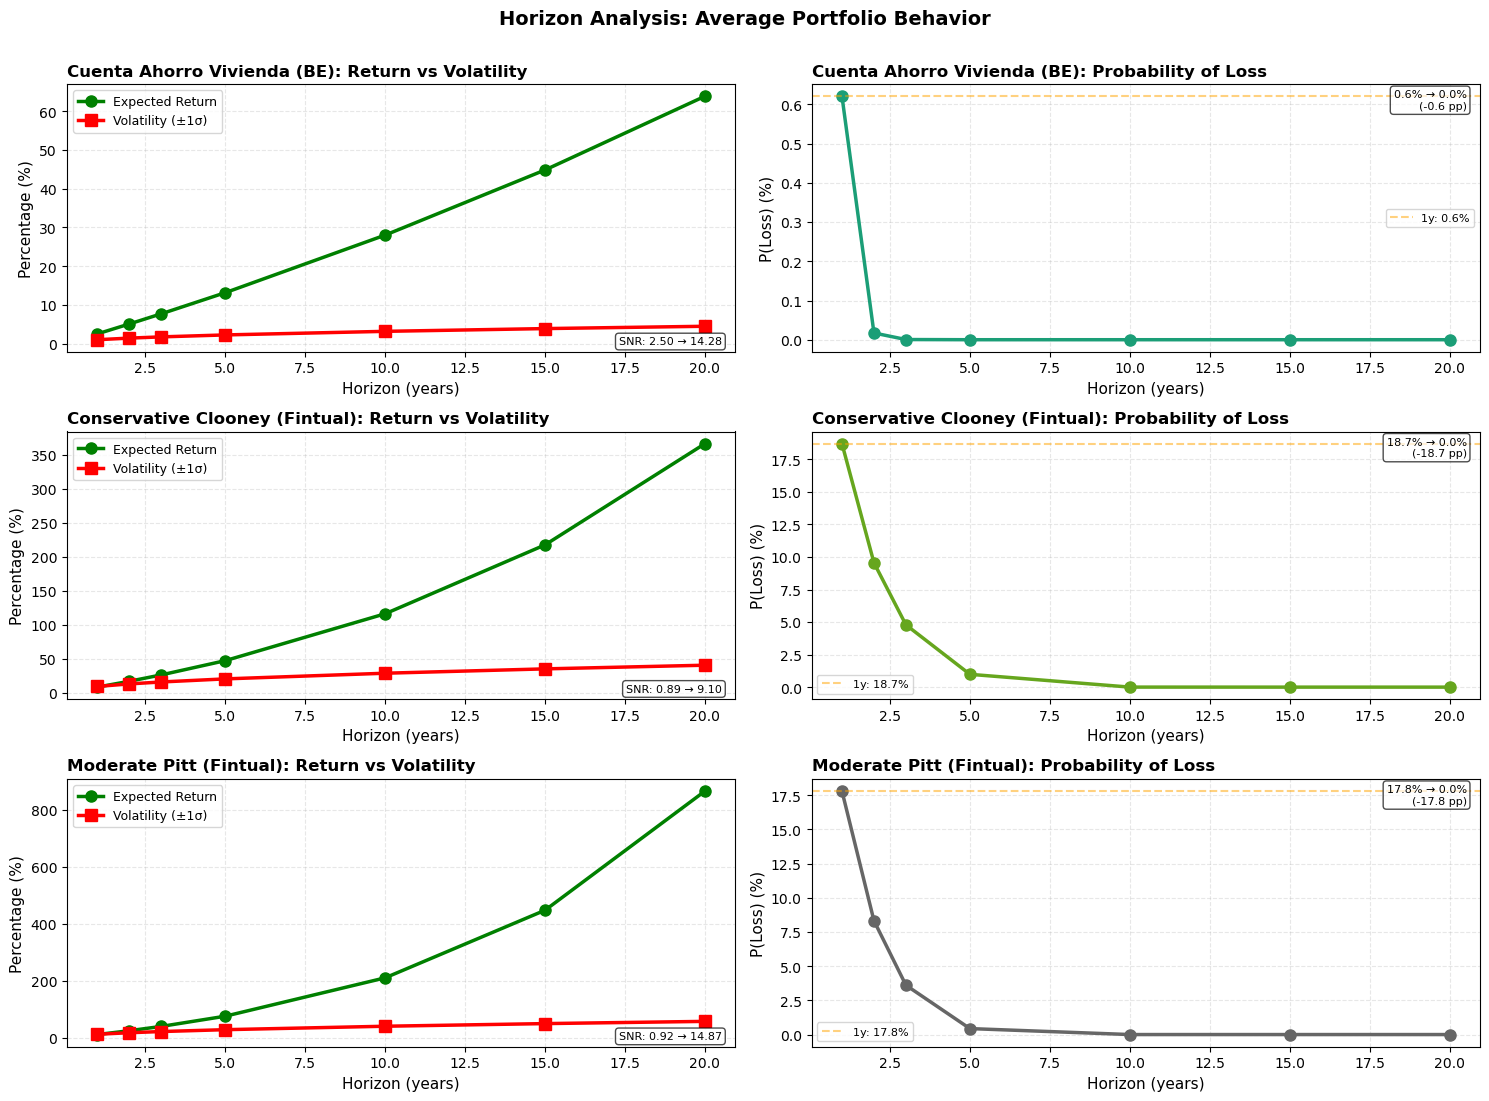

In [10]:
# --- Horizon analysis (average portfolio behavior) ---
mode = 'returns_horizon'
model.plot(mode = 'returns_horizon', show_table=False)

# Portfolio Module

## Wealth Projection Under Allocation Policy

**Recursive dynamics**: Wealth evolves as:
$$
W_{t+1}^m = (W_t^m + A_t x_t^m) \,(1 + R_t^m)
$$
We define $A_t^m = A_t \cdot x_t^m$ which is the contribution allocated to account $m$ via policy $X = \{x_t^m\}_{t,m}$.

**Closed-form representation**:
$$
W_t^m = W_0^m \, F_{0,t}^m + \sum_{s=0}^{t-1} A_s \, x_s^m \, F_{s,t}^m
$$
with accumulation factor $F_{s,t}^m = \prod_{r=s}^{t-1} (1 + R_r^m)$.

**Key insight**: $W_t^m(X)$ is **linear affine in policy** $X$ → analytical gradients enable convex optimization.

**What to observe**:
- Top-left: wealth per account with Monte Carlo trajectories
- Top-right: total wealth + final distribution histogram
- Bottom-left: portfolio composition over time
- Bottom-right: allocation policy heatmap

/home/mlioi/fin-opt/src/portfolio.py:1148: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.01, 1, 0.96 if title else 1])


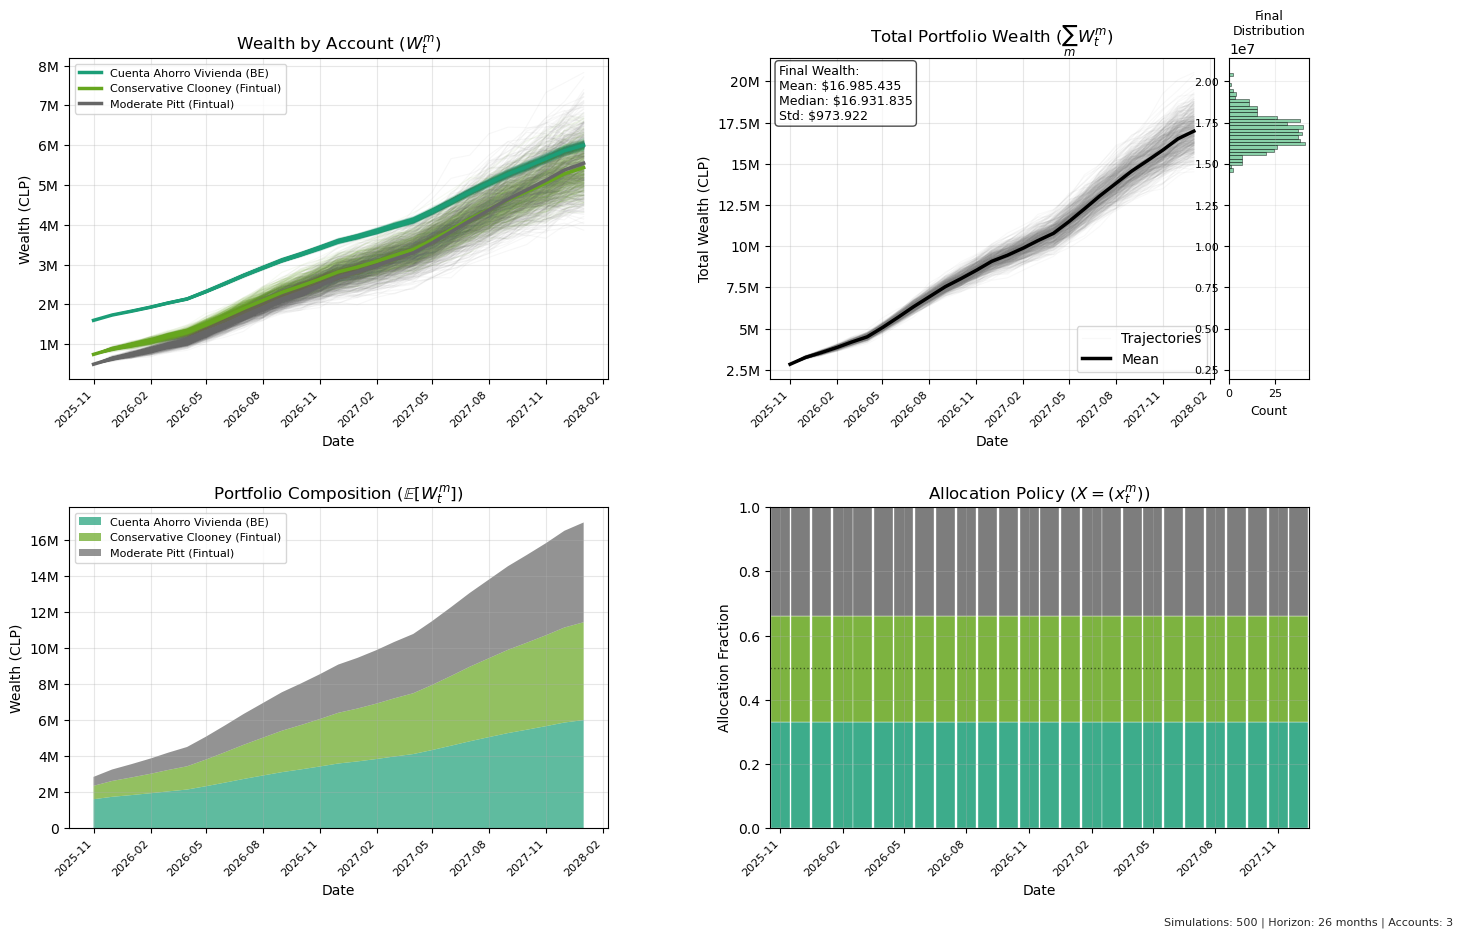

In [11]:
# Define Allocation Policy

X_static = np.tile([0.33, 0.33, 0.34], (months, 1))  # shape (months, 2)

# Project monthly Wealth
model.plot(mode = 'wealth', start=start_date, T=months, X=X_static)

# Goal-Driven Optimization

## Problem Formulation

### Non-Convex Chance Constraints

The **bilevel problem** seeks the minimum horizon $T^*$ satisfying all goals:

$$
\min_{T \in \mathbb{N}} \;\; T \max_{X \in \in \mathcal{F}_T} f(X)
$$

where the **goal-feasible set** $\mathcal{F}_T$ contains all policies $X \in \mathcal{X}_T$ satisfying probabilistic constraints:

**Intermediate goals** (at fixed time $t < T$):
$$
\mathbb{P}\big(W_t^m(X) \ge b_t^m\big) \ge 1-\varepsilon_t^m, \quad \forall g \in \mathcal{G}_{\text{int}}
$$

**Terminal goals** (at horizon $T$):
$$
\mathbb{P}\big(W_T^m(X) \ge b^m\big) \ge 1-\varepsilon^m, \quad \forall g \in \mathcal{G}_{\text{term}}
$$

with decision space (simplex):
$$
\mathcal{X}_T = \left\{ X \in \mathbb{R}^{T \times M} : x_t^m \ge 0, \; \sum_{m=1}^M x_t^m = 1, \; \forall t = 0,\ldots,T-1 \right\}
$$

**Challenge**: Chance constraints involve indicator functions $\mathbb{1}[\cdot]$, which are discontinuous and non-convex. Standard approaches (MILP, sigmoid smoothing) either scale poorly or find local optima.


## Convex Reformulation via CVaR

### CVaR Reformulation: Convex Upper Bound

We replace each chance constraint with a **CVaR constraint** (Rockafellar & Uryasev, 2000):

$$
\boxed{\mathbb{P}(W \ge b) \ge 1-\varepsilon \quad \impliedby \quad \text{CVaR}_\varepsilon(b - W) \le 0}
$$

where the **Conditional Value-at-Risk** of shortfall $L = b - W$ is:

$$
\text{CVaR}_\varepsilon(L) = \text{VaR}_\varepsilon(L) + \frac{1}{\varepsilon} \mathbb{E}\big[(L - \text{VaR}_\varepsilon(L))_+\big]
$$

**Epigraphic formulation** (convex, suitable for LP solvers):

$$
\text{CVaR}_\varepsilon(L) = \min_{\gamma \in \mathbb{R}} \left\{ \gamma + \frac{1}{\varepsilon N} \sum_{i=1}^N [L^i - \gamma]_+ \right\}
$$

Introducing auxiliary variables $z^i \ge [L^i - \gamma]_+$:

$$
\begin{aligned}
\text{CVaR}_\varepsilon(L) &= \min_{\gamma, z} \left\{ \gamma + \frac{1}{\varepsilon N} \sum_{i=1}^N z^i \right\} \\
\text{s.t.} \quad & z^i \ge L^i - \gamma, \quad \forall i \in [N] \\
& z^i \ge 0, \quad \forall i \in [N]
\end{aligned}
$$

**Key property**: If $W^i$ is **affine in $X$** (as in our wealth dynamics), then $\text{CVaR}_\varepsilon(b - W)$ is **convex in $X$**.

---

### Mathematical Relationship: Implication, Not Equivalence

**Theorem** (Rockafellar & Uryasev, 2000):

$$
\text{CVaR}_\varepsilon(L) \le 0 \quad \implies \quad \mathbb{P}(L \le 0) \ge 1 - \varepsilon
$$

**Proof sketch**: CVaR averages the worst $\varepsilon$-tail of the distribution. If this mean is non-positive, then at least $(1-\varepsilon)$ of scenarios satisfy $L \le 0$.

**The converse is NOT true**: $\mathbb{P}(L \le 0) \ge 1-\varepsilon$ does NOT imply CVaR $\le 0$ if the tail is heavy.

**Interpretation**: CVaR is a **conservative approximation** controlling both:
1. **Frequency** of violations (at most $\varepsilon \times 100\%$ scenarios fail)
2. **Severity** of violations (average loss in tail is non-positive)

The original chance constraint only controls frequency.

---

### Convex Reformulated Problem - Multiple Objectives

**Inner problem** (for fixed $T$):
$$
\begin{aligned}
\max_{X, \gamma, z} \quad & f(X) \\
\text{s.t.} \quad & \sum_{m=1}^M x_t^m = 1, \quad \forall t = 0,\ldots,T-1 \quad \text{(simplex)} \\
& x_t^m \ge 0, \quad \forall t, m \quad \text{(non-negativity)} \\
& z_g^i \ge (b_g - W_{t_g}^{i,m_g}(X)) - \gamma_g, \quad \forall g, i \quad \text{(epigraph)} \\
& z_g^i \ge 0, \quad \forall g, i \\
& \gamma_g + \frac{1}{\varepsilon_g N} \sum_{i=1}^N z_g^i \le 0, \quad \forall g \quad \text{(CVaR constraint)}
\end{aligned}
$$

where:
- $W_{t}^{i,m}(X) = W_0^m F^i_{0,t,m} + \sum_{s=0}^{t-1} A^i_s \cdot x_s^m \cdot F^i_{s,t,m}$ **(affine in** $X$**)**
- $g$ indexes goals (both intermediate and terminal)
- $t_g, m_g, b_g, \varepsilon_g$ are parameters of goal $g$
- $f(X)$ is a convex objective function (see supported objectives below)

---

**Global optimality guaranteed** via convex programming (interior-point methods).

### Comparison: Original vs. CVaR

**Observed conservativeness** (empirical):
- CVaR constraint: $\text{CVaR}_\varepsilon(L) \le 0$
- Resulting violation rate: typically $(0.5-0.8) \times \varepsilon$ (better than required)

**Example** (from our results):
- Goal: $\mathbb{P}(W_T \ge 1\text{M}) \ge 80\%$ (i.e., $\varepsilon = 20\%$)
- CVaR solution: violation rate = 9% (margin of 11%)

The 11% buffer is the "price" of convexity, buying us certified global optimality and numerical stability.

## Goal Specification

In [12]:
# --- Define Financial Goals ---

# Goal 1: Down Payment 
goal_downpayment = TerminalGoal(
    account="Conservative Clooney (Fintual)",
    threshold=5_000_000,
    confidence=0.2
)

# Goal 2: Home Purchase (Terminal)
goal_home = TerminalGoal(
    account="Moderate Pitt (Fintual)",
    threshold=8_000_000,
    confidence=0.2
)

# Goal 3: Emergency Fund
goal_emergency_intermediate = IntermediateGoal(
    account="Cuenta Ahorro Vivienda (BE)",
    threshold=3_100_000,
    confidence=0.20,
    month=6
)

goals = [goal_downpayment, goal_home, goal_emergency_intermediate]

# Display goal summary
print("=" * 70)
print("FINANCIAL GOALS SUMMARY")
print("=" * 70)
for i, g in enumerate(goals, 1):
    if isinstance(g, IntermediateGoal):
        print(f"\n{i}.")
        print(f"   Type: Intermediate (month {g.month})")
        print(f"   Account: {g.account}")
        print(f"   Threshold: ${g.threshold:,.0f}")
        print(f"   Confidence: {g.confidence:.0%} (ε={g.epsilon:.0%})")
    else:
        print(f"\n{i}.")
        print(f"   Type: Terminal (horizon T to be optimized)")
        print(f"   Account: {g.account}")
        print(f"   Threshold: ${g.threshold:,.0f}")
        print(f"   Confidence: {g.confidence:.0%} (ε={g.epsilon:.0%})")
print("=" * 70)

FINANCIAL GOALS SUMMARY

1.
   Type: Terminal (horizon T to be optimized)
   Account: Conservative Clooney (Fintual)
   Threshold: $5,000,000
   Confidence: 20% (ε=80%)

2.
   Type: Terminal (horizon T to be optimized)
   Account: Moderate Pitt (Fintual)
   Threshold: $8,000,000
   Confidence: 20% (ε=80%)

3.
   Type: Intermediate (month 6)
   Account: Cuenta Ahorro Vivienda (BE)
   Threshold: $3,100,000
   Confidence: 20% (ε=80%)


## Bilevel Optimization

### Supported Convex Objectives

CVaROptimizer supports 7 convex objectives exploiting affine wealth structure: $W_{t}^{i,m}(X) = W_0^m F^i_{0,t,m} + \sum_{s=0}^{t-1} A^i_s \cdot x_s^m \cdot F^i_{s,t,m}$

**1. terminal_wealth** — Growth maximization
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] = \frac{1}{N}\sum_{i=1}^N \sum_{m=1}^M W_T^{i,m}(X)
$$

**2. min_cvar** — Downside protection
$$
\min_{X, \gamma, z} \quad \sum_{g \in \mathcal{G}} \left(\gamma_g + \frac{1}{\varepsilon_g N}\sum_{i=1}^N z_g^i\right)
$$

**3. low_turnover** — Tax efficiency (`lambda=0.1`)
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] - \lambda \sum_{t=1}^{T-1}\sum_{m=1}^M |x_t^m - x_{t-1}^m|
$$

**4. risk_adjusted** — Markowitz mean-variance (`lambda=0.5`)
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] - \lambda \cdot \text{Var}\left(\sum_{m=1}^M W_T^m\right)
$$
where $\displaystyle \text{Var}(W_T) = \frac{1}{N}\sum_{i=1}^N\left(W_T^i - \mathbb{E}[W_T]\right)^2$

**5. balanced** — Multi-objective (`lambda_risk=0.3`, `lambda_turnover=0.05`)
$$
\max_{X} \quad \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] - \lambda_r \cdot \text{Var}\left(\sum_{m=1}^M W_T^m\right) - \lambda_t \sum_{t=1}^{T-1}\sum_{m=1}^M |x_t^m - x_{t-1}^m|
$$

**6. min_variance** — Capital preservation (`target` **required**)
$$
\begin{aligned}
\min_{X} \quad & \text{Var}\left(\sum_{m=1}^M W_T^m\right) \\
\text{s.t.} \quad & \mathbb{E}\left[\sum_{m=1}^M W_T^m\right] \ge W_{\text{target}}
\end{aligned}
$$

In [13]:
# --- Execute Optimization ---

print("\n" + "=" * 70)
print("STARTING BILEVEL OPTIMIZATION")

optimizer = CVaROptimizer(n_accounts=model.M, objective='low_turnover', objective_params= {'lambda': 500})
opt_result = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=120,
    n_sims=400,
    seed=42,
    verbose=True,
    solver='ECOS',  # O 'SCS', 'CLARABEL'
    max_iters=100000)

print(opt_result.summary())

# Display optimization summary
print("\n" + "=" * 70)
print(opt_result.summary())
print("=" * 70)


STARTING BILEVEL OPTIMIZATION

=== GoalSeeker: BINARY search T ∈ [6, 120] ===
[Iter 1] Binary search: testing T=63 (range=[6, 120])...
    ✓ Feasible, obj=52849782.82, time=0.659s

[Iter 2] Binary search: testing T=34 (range=[6, 63])...
    ✓ Feasible, obj=23819530.96, time=0.201s

[Iter 3] Binary search: testing T=20 (range=[6, 34])...
    ✗ Infeasible, obj=0.00, time=0.066s

[Iter 4] Binary search: testing T=27 (range=[21, 34])...
    ✓ Feasible, obj=17928241.47, time=0.221s

[Iter 5] Binary search: testing T=24 (range=[21, 27])...
    ✗ Infeasible, obj=0.00, time=0.094s

[Iter 6] Binary search: testing T=26 (range=[25, 27])...
    ✓ Feasible, obj=17219523.13, time=0.141s

[Iter 7] Binary search: testing T=25 (range=[25, 26])...
    ✗ Infeasible, obj=0.00, time=0.879s

=== Optimal: T*=26 (binary search converged) ===

OptimizationResult(
  Status: ✓ Feasible
  Horizon: T=26 months
  Objective: 17219523.13
  Goals: 3 (1 intermediate, 2 terminal)
  Solve time: 0.141s
  Iterations: 0
)

In [14]:
optimizer.objective

'low_turnover'

## Optimal Policy Analysis

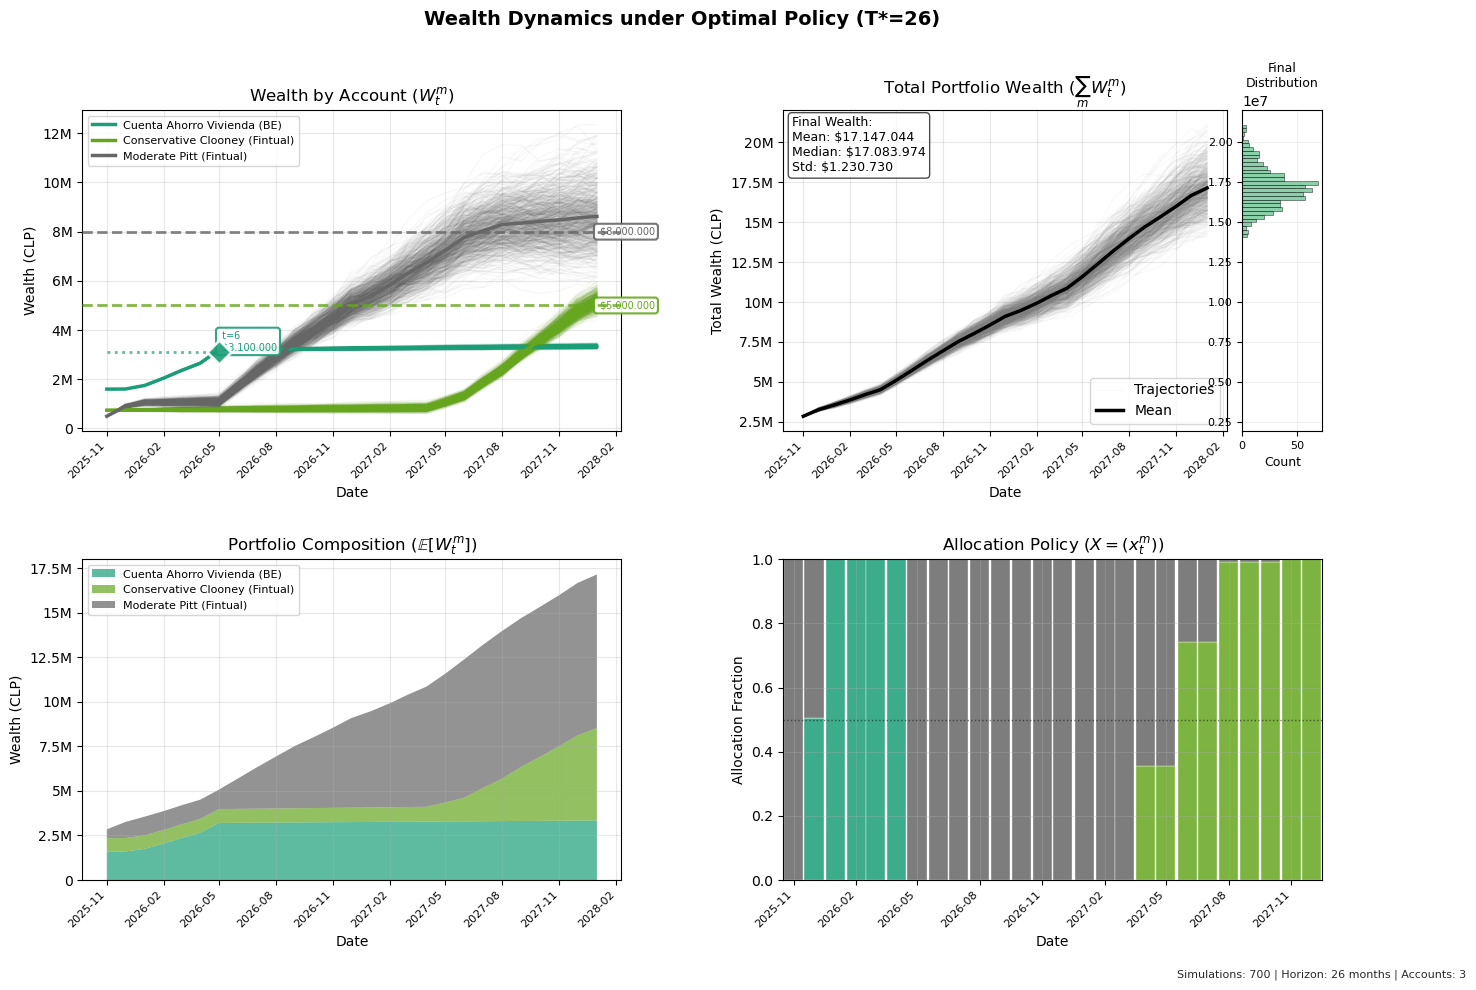

In [15]:
# --- Simulate wealth under X* ---

# Generate fresh scenarios for validation (out-of-sample)
opt_sim = model.simulate_from_optimization(
    opt_result,
    n_sims=700,
    seed=999  # Different seed from optimization
)

# Plot wealth dynamics
model.plot(
    mode='wealth',
    result=opt_sim,
    X=opt_result.X,
    title=f"Wealth Dynamics under Optimal Policy (T*={opt_result.T})",
    show_trajectories=True,
    goals=goals
)

## Goal Verification

### In-Sample Verification

In [18]:
print("=" * 70)
print("GOAL VERIFICATION: IN-SAMPLE")
print("=" * 70)
print("Using optimization scenarios (n=300, seed=42)")
print("Expected: All goals satisfied (✓)\n")

# Simulate with optimization parameters
insample_sim = model.simulate(
    T=opt_result.T,
    X=opt_result.X,
    n_sims=300,
    seed=42,  # Same seed as optimization
    start=start_date
)

insample_status = model.verify_goals(insample_sim, goals, start=start_date)

# Display results
for goal, metrics in insample_status.items():
    print(f"  Account: {goal.account}")
    if isinstance(goal, IntermediateGoal):
        print(f"  Month: {goal.month}")
    print(f"  Threshold: ${goal.threshold:,.0f}")
    print(f"  Confidence: {goal.confidence:.0%}")
    print(f"  ---")
    status_symbol = "✓" if metrics['satisfied'] else "✗"
    print(f"  Status: {status_symbol} {'SATISFIED' if metrics['satisfied'] else 'VIOLATED'}")
    print(f"  Violation rate: {metrics['violation_rate']:.2%} (required ≤ {metrics['required_rate']:.2%})")
    print(f"  Margin: {metrics['margin']:.2%}")
    print(f"  Median shortfall: ${metrics['median_shortfall']:,.0f}")
    print(f"  N violations: {metrics['n_violations']} / {insample_sim.n_sims}")

print("\n" + "=" * 70)

GOAL VERIFICATION: IN-SAMPLE
Using optimization scenarios (n=300, seed=42)
Expected: All goals satisfied (✓)

  Account: Conservative Clooney (Fintual)
  Threshold: $5,000,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 23.67% (required ≤ 80.00%)
  Margin: 56.33%
  Median shortfall: $112,700
  N violations: 71 / 300
  Account: Moderate Pitt (Fintual)
  Threshold: $8,000,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 30.00% (required ≤ 80.00%)
  Margin: 50.00%
  Median shortfall: $476,569
  N violations: 90 / 300
  Account: Cuenta Ahorro Vivienda (BE)
  Month: 6
  Threshold: $3,100,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 0.00% (required ≤ 80.00%)
  Margin: 80.00%
  Median shortfall: $0
  N violations: 0 / 300



### Out-of-Sample Verification

In [20]:
print("\n" + "=" * 70)
print("GOAL VERIFICATION: OUT-OF-SAMPLE")
print("=" * 70)
print("Using fresh scenarios (n=1000, seed=999)")
print("Expected: All goals satisfied with safety margin\n")

# Generate independent scenarios
outsample_sim = model.simulate_from_optimization(
    opt_result,
    n_sims=1000,
    seed=999  # Independent seed
)

outsample_status = model.verify_goals(outsample_sim, goals, start=start_date)

# Display results
for goal, metrics in outsample_status.items():
    print(f"  Account: {goal.account}")
    if isinstance(goal, IntermediateGoal):
        print(f"  Month: {goal.month}")
    print(f"  Threshold: ${goal.threshold:,.0f}")
    print(f"  Confidence: {goal.confidence:.0%}")
    print(f"  ---")
    status_symbol = "✓" if metrics['satisfied'] else "✗"
    print(f"  Status: {status_symbol} {'SATISFIED' if metrics['satisfied'] else 'VIOLATED'}")
    print(f"  Violation rate: {metrics['violation_rate']:.2%} (required ≤ {metrics['required_rate']:.2%})")
    print(f"  Margin: {metrics['margin']:.2%}")
    print(f"  Median shortfall: ${metrics['median_shortfall']:,.0f}")
    print(f"  N violations: {metrics['n_violations']} / {outsample_sim.n_sims}")

print("\n" + "=" * 70)

# Summary comparison
print("\n" + "=" * 70)
print("IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON")
print("=" * 70)

comparison = pd.DataFrame({
    'In-Sample (n=300)': [
        insample_status[g]['violation_rate'] for g in goals
    ],
    'Out-of-Sample (n=1000)': [
        outsample_status[g]['violation_rate'] for g in goals
    ],
    'Required (ε)': [
        g.epsilon for g in goals
    ]
})

print(comparison.round(4))
print("=" * 70)


GOAL VERIFICATION: OUT-OF-SAMPLE
Using fresh scenarios (n=1000, seed=999)
Expected: All goals satisfied with safety margin

  Account: Conservative Clooney (Fintual)
  Threshold: $5,000,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 25.00% (required ≤ 80.00%)
  Margin: 55.00%
  Median shortfall: $118,257
  N violations: 250 / 1000
  Account: Moderate Pitt (Fintual)
  Threshold: $8,000,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 27.60% (required ≤ 80.00%)
  Margin: 52.40%
  Median shortfall: $509,168
  N violations: 276 / 1000
  Account: Cuenta Ahorro Vivienda (BE)
  Month: 6
  Threshold: $3,100,000
  Confidence: 20%
  ---
  Status: ✓ SATISFIED
  Violation rate: 0.00% (required ≤ 80.00%)
  Margin: 80.00%
  Median shortfall: $0
  N violations: 0 / 1000


IN-SAMPLE vs OUT-OF-SAMPLE COMPARISON
   In-Sample (n=300)  Out-of-Sample (n=1000)  Required (ε)
0             0.2367                   0.250           0.8
1             0.3000               

In [63]:
!jupyter nbconvert \
  --to pdf \
  --TagRemovePreprocessor.enabled=True \
  --TagRemovePreprocessor.remove_input_tags="['hide_input']" \
  FinOpt-Workflow.ipynb

[NbConvertApp] Converting notebook FinOpt-Workflow.ipynb to pdf
[NbConvertApp] Support files will be in FinOpt-Workflow_files/
[NbConvertApp] Making directory ./FinOpt-Workflow_files
[NbConvertApp] Writing 54554 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2166839 bytes to FinOpt-Workflow.pdf


In [43]:
!jupyter nbconvert \
  --to html \
  --TagRemovePreprocessor.enabled=True \
  --TagRemovePreprocessor.remove_input_tags="['hide_input']" \
  FinOpt-Workflow.ipynb

[NbConvertApp] Converting notebook FinOpt-Workflow.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 3675874 bytes to FinOpt-Workflow.html
